In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob as glob
import json

In [14]:
mininet_root = "./data/mininet/2020-10-23_10-47-36/"

def build_file_list(directory,clip=None):
    ret_val = [] 
    files = glob.glob(directory+"*",recursive=True)
    print("TOTAL DIRECTORIES {0}".format(len(files)))
    for idx, dir_name in enumerate(files):
        if clip is not None and idx > clip:
            break
        file_set = {}
        runs = glob.glob(dir_name+"/*",recursive=True)
        for run in runs:
            values = run.split("/")
            file_set["experiment"] = values[-2]
            file_set["run"] = values[-1]
            test = glob.glob(run+"/*",recursive=True)
            for t in test:
                if t.find(".json") >= 0:
                    file_set["json"] = t
                if t.find("pub_log") >= 0 :
                    file_set["pub_csv"] = t
                if t.find("sub_log") >= 0 :
                    file_set["sub_csv"] = t                
            ret_val.append(file_set)
    return ret_val
file_list = build_file_list(mininet_root)
print("Total files to process is 3x{0} = {1}".format(len(file_list),3*len(file_list)))


TOTAL DIRECTORIES 90
Total files to process is 3x900 = 2700


In [18]:
def process_mininet_test(json_file,pub_file,sub_file):
    result = {}
    result["json_fname"] = json_file
    with open(json_file,"r") as fptr:
        result.update(json.load(fptr))
    result.update(collapse_csv_file(pub_file,"pub_"))
    result.update(collapse_csv_file(sub_file,"sub_"))
    result["lost_prct"] = 100.0*result["sub_sum_lost"]/result["pub_sum_sent"]    
    return result

def collapse_csv_file(csv_file,prefix):
    df = pd.read_csv(csv_file,header=21,na_values=["inf","-inf","-nan","nan","NaN"])
    new_cols = [prefix+"mean_"+c.strip("\t") for c in df.columns]
    df.columns = new_cols
    df = df.fillna(0)
    ret_val = df.mean().to_dict()
    # A lot more metric extraction could go here but for now just take the column means
    # df = df.replace([np.inf, -np.inf, np.nan],0)
    # these values aren't the mean, it is just the name
    ret_val[prefix+"sum_sent"] = df[prefix+"mean_"+"sent"].sum()
    ret_val[prefix+"sum_recv"] = df[prefix+"mean_"+"received"].sum()
    ret_val[prefix+"sum_lost"] = df[prefix+"mean_"+"lost"].sum()
    return ret_val

def process_mininet_dataset(file_list):
    ret_val = []
    i = 0
    for f in file_list:
        if len(f.keys()) != 5:
            print( "Ignoring: {0}".format(f))
            continue # dead simple validity check as there are some config files
        i += 1
        out = process_mininet_test(f["json"],f["pub_csv"],f["sub_csv"])
        out["experiment"] = f["experiment"]
        out["run"] = f["run"]
        if i%150==0:
            print(i,f)

        ret_val.append(out)
    print("Total complete {0}".format(len(ret_val)))
    return  pd.DataFrame(ret_val).fillna(0)
    
print("Processing {0} files.".format(len(file_list)))
df = process_mininet_dataset(file_list)
df.head()
df.to_csv("MininetResults.csv")

Processing 900 files.
150 {'experiment': 'rmw_fastrtps_cpp_sync_Array1k@30_reliable_volatile_keep_last@10_1000bw_20loss_0delay', 'run': 'run01', 'pub_csv': './data/mininet/2020-10-23_10-47-36/rmw_fastrtps_cpp_sync_Array1k@30_reliable_volatile_keep_last@10_1000bw_20loss_0delay/run01/pub_log_Array1k_23-10-2020_16-01-38', 'sub_csv': './data/mininet/2020-10-23_10-47-36/rmw_fastrtps_cpp_sync_Array1k@30_reliable_volatile_keep_last@10_1000bw_20loss_0delay/run01/sub_log_Array1k_23-10-2020_16-01-38', 'json': './data/mininet/2020-10-23_10-47-36/rmw_fastrtps_cpp_sync_Array1k@30_reliable_volatile_keep_last@10_1000bw_20loss_0delay/run01/experiment_config.json'}
300 {'experiment': 'rmw_fastrtps_cpp_async_PointCloud512k@30_reliable_volatile_keep_last@10_54bw_10loss_0delay', 'run': 'run01', 'sub_csv': './data/mininet/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_PointCloud512k@30_reliable_volatile_keep_last@10_54bw_10loss_0delay/run01/sub_log_PointCloud512k_23-10-2020_11-02-55', 'pub_csv': './data/minine

In [5]:
#df.replace([np.NaN,np.nan],0)
df.head()


,json_fname,rmw_implementation,bandwidth,loss,delay,message_rate,message_type,reliability,durability,history_kind,...,sub_mean_ru_nvcsw,sub_mean_ru_nivcsw,sub_mean_cpu_usage (%),sub_sum_sent,sub_sum_recv,sub_sum_lost,lost_prct,sub_mean_latency_min (ms),sub_mean_latency_max (ms),sub_mean_latency_variance (ms)
0,./data/mininet/2020-10-16_01-34-11/rmw_cyclone...,rmw_cyclonedds_cpp,300,40,0,30,PointCloud512k,reliable,volatile,keep_last,...,90.888889,0.777778,0.127601,0,0,0,0.0,0.0,0.0,0.0
1,./data/mininet/2020-10-16_01-34-11/rmw_fastrtp...,rmw_fastrtps_cpp,300,40,0,30,Array1k,reliable,volatile,keep_last,...,233.400000,1.933333,0.142150,0,0,0,0.0,0.0,0.0,0.0
2,./data/mininet/2020-10-16_01-34-11/rmw_fastrtp...,rmw_fastrtps_cpp,300,40,0,30,Array1m,reliable,volatile,keep_last,...,189.888889,1.444444,0.228181,0,0,0,0.0,0.0,0.0,0.0
3,./data/mininet/2020-10-16_01-34-11/rmw_cyclone...,rmw_cyclonedds_cpp,300,40,0,30,PointCloud2m,reliable,volatile,keep_last,...,185.466667,1.600000,0.136781,0,0,0,0.0,0.0,0.0,0.0
4,./data/mininet/2020-10-16_01-34-11/rmw_cyclone...,rmw_cyclonedds_cpp,54,20,0,30,PointCloud512k,reliable,volatile,keep_last,...,829.066667,5.933333,0.186258,0,0,0,0.0,0.0,0.0,0.0


In [6]:
print("RMW in set:")
print(df.rmw_implementation.unique())
print("Bandwidth in set:")
print(df.bandwidth.unique())
print("Loss set:")
print(df.loss.unique())
print("Delay set:")
print(df.delay.unique())
print("Message rate set:")
print(df.message_rate.unique())
print("Message type set:")
print(df.message_type.unique())
cyclone_df = df[df["rmw_implementation"]=="rmw_cyclonedds_cpp"]
fast_df = df[df["rmw_implementation"]=="rmw_fastrtps_cpp"]

RMW in set:
['rmw_cyclonedds_cpp' 'rmw_fastrtps_cpp']
Bandwidth in set:
[ 300   54 1000]
Loss set:
[40 20 30  0 10]
Delay set:
[0]
Message rate set:
[30]
Message type set:
['PointCloud512k' 'Array1k' 'Array1m' 'PointCloud2m']


In [7]:
def slice_mininet_data_bw_loss(vendor_df, dep_variable,msg_rate,msg_type):
    temp = vendor_df[vendor_df["message_rate"] == msg_rate ]
    temp = temp[temp["message_type"] == msg_type ]
    print(len(temp))

slice_mininet_data_bw_loss(fast_df,None,100,"Array1m")

0


In [10]:
print("Fast {0} of {1}".format(len(fast_df[fast_df['lost_prct']>0]),len(fast_df)))
print("Cyclone {0} of {1}".format(len(cyclone_df[cyclone_df['lost_prct']>0]),len(cyclone_df)))
#print("Fast {0} of {1}".format(len(fast_df[fast_df['mean_sub_lost']>0]),len(fast_df)))
#print("Cyclone {0} of {1}".format(len(cyclone_df[cyclone_df['mean_sub_lost']>0]),len(cyclone_df)))
print("Fast {0} of {1}".format(len(fast_df[fast_df["sub_mean_latency_max (ms)"]>0]),len(fast_df)))
print("Cyclone {0} of {1}".format(len(cyclone_df[cyclone_df["sub_mean_latency_max (ms)"]>0]),len(cyclone_df)))


Fast 15 of 60
Cyclone 9 of 60
Fast 15 of 60
Cyclone 16 of 60


In [11]:
print(fast_df.columns)

Index(['json_fname', 'rmw_implementation', 'bandwidth', 'loss', 'delay',
       'message_rate', 'message_type', 'reliability', 'durability',
       'history_kind', 'history_depth', 'pub_mean_T_experiment',
       'pub_mean_T_loop', 'pub_mean_received', 'pub_mean_sent',
       'pub_mean_lost', 'pub_mean_relative_loss', 'pub_mean_data_received',
       'pub_mean_latency_mean (ms)', 'pub_mean_latency_variance (ms)',
       'pub_mean_pub_loop_res_min (ms)', 'pub_mean_pub_loop_res_max (ms)',
       'pub_mean_pub_loop_res_mean (ms)',
       'pub_mean_pub_loop_res_variance (ms)',
       'pub_mean_sub_loop_res_mean (ms)',
       'pub_mean_sub_loop_res_variance (ms)', 'pub_mean_ru_utime',
       'pub_mean_ru_stime', 'pub_mean_ru_maxrss', 'pub_mean_ru_ixrss',
       'pub_mean_ru_idrss', 'pub_mean_ru_isrss', 'pub_mean_ru_minflt',
       'pub_mean_ru_majflt', 'pub_mean_ru_nswap', 'pub_mean_ru_inblock',
       'pub_mean_ru_oublock', 'pub_mean_ru_msgsnd', 'pub_mean_ru_msgrcv',
       'pub_mean_ru_ns

In [13]:
to_plot = []
cutoff = 1
temp = cyclone_df[cyclone_df['lost_prct']>cutoff]
for i in range(0,len(temp)):
    print("Cyclone lost packets with average magnitude: {0} for BW{1}-L{2}-R{3}-{4}".format(temp.iloc[i].lost_prct,temp.iloc[i].bandwidth,temp.iloc[i].loss,temp.iloc[i].message_rate,temp.iloc[i].message_type,temp.iloc[i].json_fname))
    sample = (temp.iloc[i].bandwidth,
              temp.iloc[i].loss,
              temp.iloc[i].message_type)
    to_plot.append(sample)
print("----------------")
temp = fast_df[fast_df['lost_prct']>cutoff]
for i in range(0,len(temp)):
    print("Fast lost packets with average magnitude: {0} for BW{1}-L{2}-R{3}-{4}".format(temp.iloc[i].lost_prct,temp.iloc[i].bandwidth,temp.iloc[i].loss,temp.iloc[i].message_rate,temp.iloc[i].message_type,temp.iloc[i].json_fname))
    sample = (temp.iloc[i].bandwidth,
              temp.iloc[i].loss,
              temp.iloc[i].message_type)
    to_plot.append(sample)

Cyclone lost packets with average magnitude: 3.6613272311212817 for BW300-L10-R30-Array1k
Cyclone lost packets with average magnitude: 1.6018306636155606 for BW1000-L10-R30-Array1k
Cyclone lost packets with average magnitude: 8.009153318077804 for BW1000-L20-R30-Array1k
Cyclone lost packets with average magnitude: 20.91254752851711 for BW54-L20-R30-Array1k
Cyclone lost packets with average magnitude: 99.23954372623574 for BW300-L30-R30-Array1k
Cyclone lost packets with average magnitude: 6.349206349206349 for BW54-L10-R30-Array1m
Cyclone lost packets with average magnitude: 8.924485125858123 for BW54-L10-R30-Array1k
Cyclone lost packets with average magnitude: 14.645308924485127 for BW300-L20-R30-Array1k
Cyclone lost packets with average magnitude: 60.411899313501145 for BW1000-L30-R30-Array1k
----------------
Fast lost packets with average magnitude: 54.332552693208434 for BW54-L0-R30-PointCloud512k
Fast lost packets with average magnitude: 74.93734335839599 for BW54-L0-R30-Array1m
Fa

In [16]:
cutoff = 30
print(cutoff)
temp = cyclone_df[cyclone_df['sub_mean_latency_mean (ms)'] > cutoff]
for i in range(0,len(temp)):
    print("Cyclone latency with average magnitude: {0} for BW{1}-L{2}-R{3}-{4}".format(temp.iloc[i]["sub_mean_latency_mean (ms)"],temp.iloc[i].bandwidth,temp.iloc[i].loss,temp.iloc[i].message_rate,temp.iloc[i].message_type,temp.iloc[i].json_fname))
    sample = (temp.iloc[i].bandwidth,
              temp.iloc[i].loss,
              temp.iloc[i].message_type)
    to_plot.append(sample)

print("----------------")
temp = fast_df[fast_df['sub_mean_latency_mean (ms)'] > cutoff]
for i in range(0,len(temp)):
    print("Fast latency with average magnitude: {0} for BW{1}-L{2}-R{3}-{4}".format(temp.iloc[i]["sub_mean_latency_mean (ms)"],temp.iloc[i].bandwidth,temp.iloc[i].loss,temp.iloc[i].message_rate,temp.iloc[i].message_type,temp.iloc[i].json_fname))
    sample = (temp.iloc[i].bandwidth,
              temp.iloc[i].loss,
              temp.iloc[i].message_type)
    to_plot.append(sample)
    

30
Cyclone latency with average magnitude: 353.6066666666666 for BW54-L0-R30-PointCloud2m
Cyclone latency with average magnitude: 95.8133333333333 for BW1000-L20-R30-Array1k
Cyclone latency with average magnitude: 30.812000000000005 for BW300-L0-R30-Array1m
Cyclone latency with average magnitude: 101.92111111111112 for BW54-L20-R30-Array1k
Cyclone latency with average magnitude: 37.099999999999994 for BW300-L30-R30-Array1k
Cyclone latency with average magnitude: 63.15333333333333 for BW54-L10-R30-Array1m
Cyclone latency with average magnitude: 183.70666666666668 for BW54-L0-R30-Array1m
Cyclone latency with average magnitude: 63.97000000000001 for BW300-L0-R30-PointCloud2m
Cyclone latency with average magnitude: 131.89999999999998 for BW300-L20-R30-Array1k
Cyclone latency with average magnitude: 220.06666666666672 for BW1000-L30-R30-Array1k
Cyclone latency with average magnitude: 99.09733333333332 for BW54-L0-R30-PointCloud512k
----------------
Fast latency with average magnitude: 443.3

In [17]:
plot_set = set(to_plot)
print("Total runs collected {0}".format(len(to_plot)))
print("Total runs to plot {0}".format(len(plot_set)))
print(sorted(plot_set))
bw_54 = sorted([p for p in plot_set if p[0] == 54])
bw_300 = sorted([p for p in plot_set if p[0] == 300])
bw_1000 = sorted([p for p in plot_set if p[0] == 1000])
print("{0} BW=54 plots".format(len(bw_54)))
print("{0} BW=300 plots".format(len(bw_300)))
print("{0} BW=1000 plots".format(len(bw_1000)))

Total runs collected 52
Total runs to plot 14
[(54, 0, 'Array1m'), (54, 0, 'PointCloud2m'), (54, 0, 'PointCloud512k'), (54, 10, 'Array1k'), (54, 10, 'Array1m'), (54, 20, 'Array1k'), (300, 0, 'Array1m'), (300, 0, 'PointCloud2m'), (300, 10, 'Array1k'), (300, 20, 'Array1k'), (300, 30, 'Array1k'), (1000, 10, 'Array1k'), (1000, 20, 'Array1k'), (1000, 30, 'Array1k')]
6 BW=54 plots
5 BW=300 plots
3 BW=1000 plots


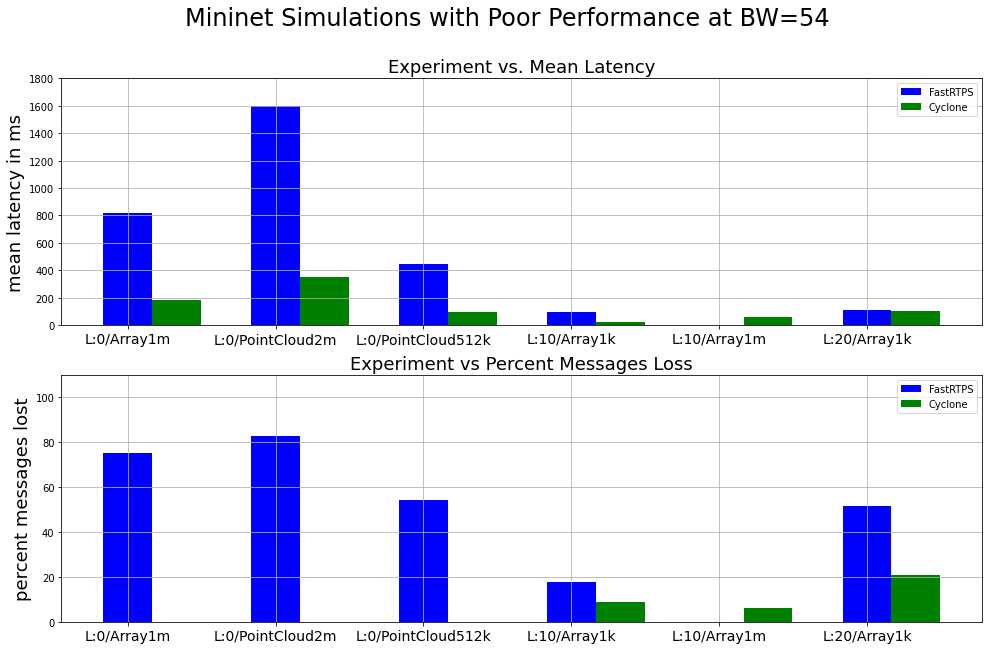

In [49]:
def generate_mininet_plot(fast_df, cyclone_df, render_set,super_title):
    to_plot = ['sub_mean_latency_mean (ms)','lost_prct'] #,'mean_sub_cpu_usage (%)']
    plot_units = ['mean latency in ms',"percent messages lost"]#"CPU Utilization %"]
    titles = ["Experiment vs. Mean Latency", "Experiment vs Percent Messages Loss"]#,"Experiment vs CPU Utilization %"]
    y_extents = [[0,1800],[0,110]]
    fig, ax = plt.subplots(len(to_plot))
    fig.set_size_inches(16.5,10) 
    fig.suptitle(super_title,fontsize=24)
    for idx,data_point in enumerate(to_plot):
        fast = []
        cyclone = [] 
        x_label = []
        for render in render_set:
            x_label.append("L:{0}/{1}".format(render[1],render[2]))
            fv = fast_df.loc[(fast_df['bandwidth'] == render[0]) & (fast_df["loss"] == render[1]) & (fast_df["message_type"]==render[2])]
            fast.append(fv[data_point].values[0])
            cv = cyclone_df.loc[(cyclone_df['bandwidth'] == render[0]) & 
                                (cyclone_df["loss"] == render[1]) & 
                                (cyclone_df["message_type"] == render[2])]
            cyclone.append(cv[data_point].values[0])
            
        x = np.arange(len(render_set))
        sz = 0.33
        ax[idx].grid(which="both")
        ax[idx].bar(x + 0.00, fast, color = 'b', width = sz,label="FastRTPS")
        ax[idx].bar(x + sz, cyclone, color = 'g', width = sz,label="Cyclone")
        ax[idx].set_ylim(y_extents[idx])
        ax[idx].set_xticks(x)
        ax[idx].set_xticklabels(x_label,rotation=0,fontsize=14)
        ax[idx].set_ylabel(plot_units[idx],fontsize=18)
        #ax[idx].set_xlabel("Mininet Experimental Conditions")
        ax[idx].set_title(titles[idx],fontsize=18)
        ax[idx].legend()
    return fig

out = generate_mininet_plot(fast_df,cyclone_df,bw_54,"Mininet Simulations with Poor Performance at BW=54")    
plt.savefig("PoorPerformersBW54.png")

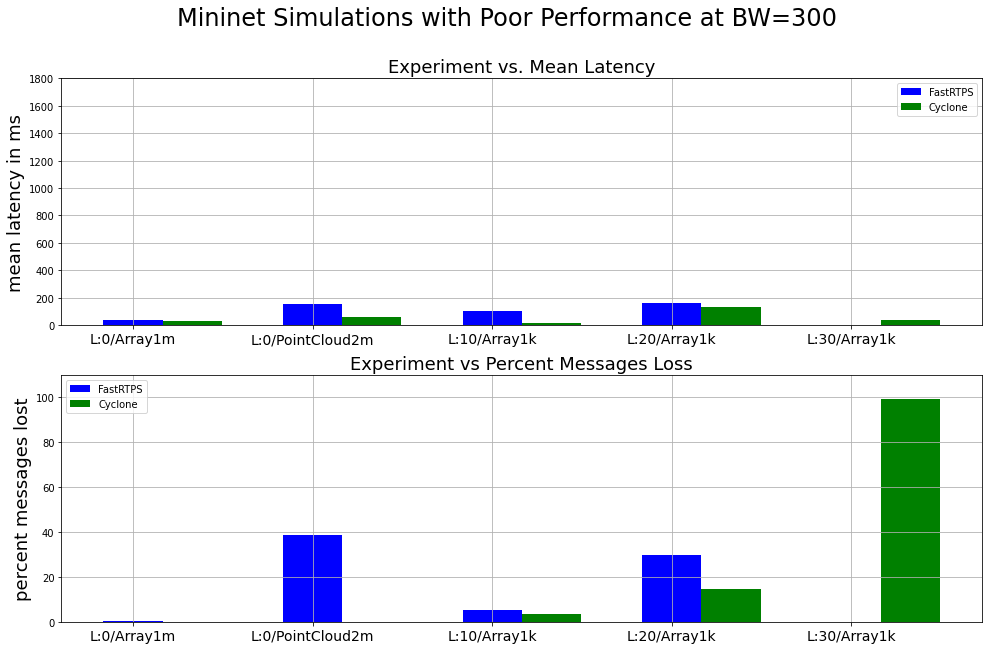

In [47]:
out = generate_mininet_plot(fast_df,cyclone_df,bw_300,"Mininet Simulations with Poor Performance at BW=300")    
plt.savefig("PoorPerformersBW300.png")

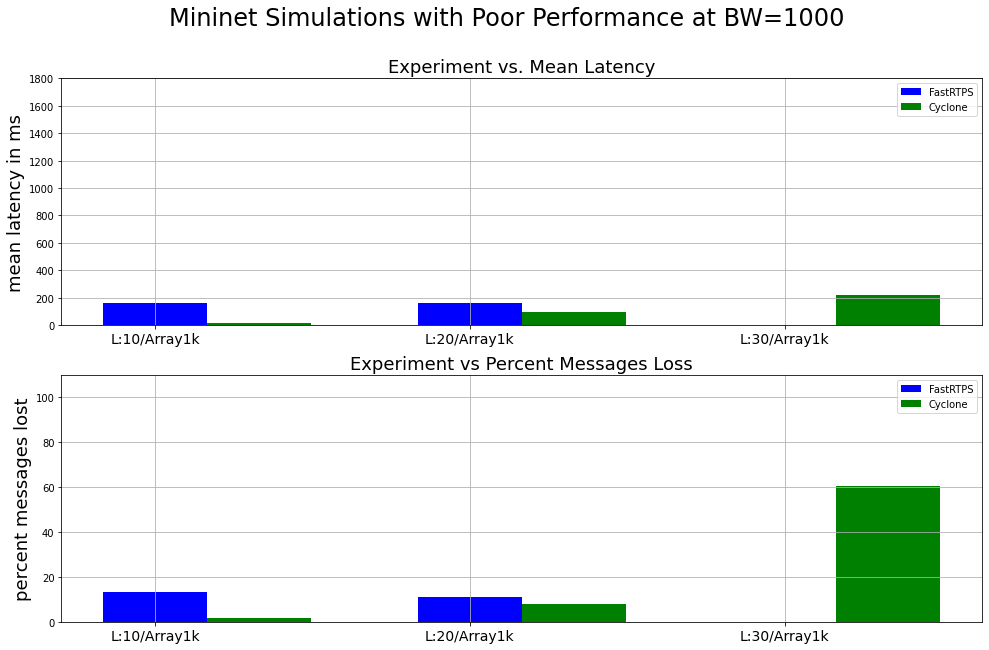

In [51]:
out = generate_mininet_plot(fast_df,cyclone_df,bw_1000,"Mininet Simulations with Poor Performance at BW=1000")    
plt.savefig("PoorPerformersBW1000.png")

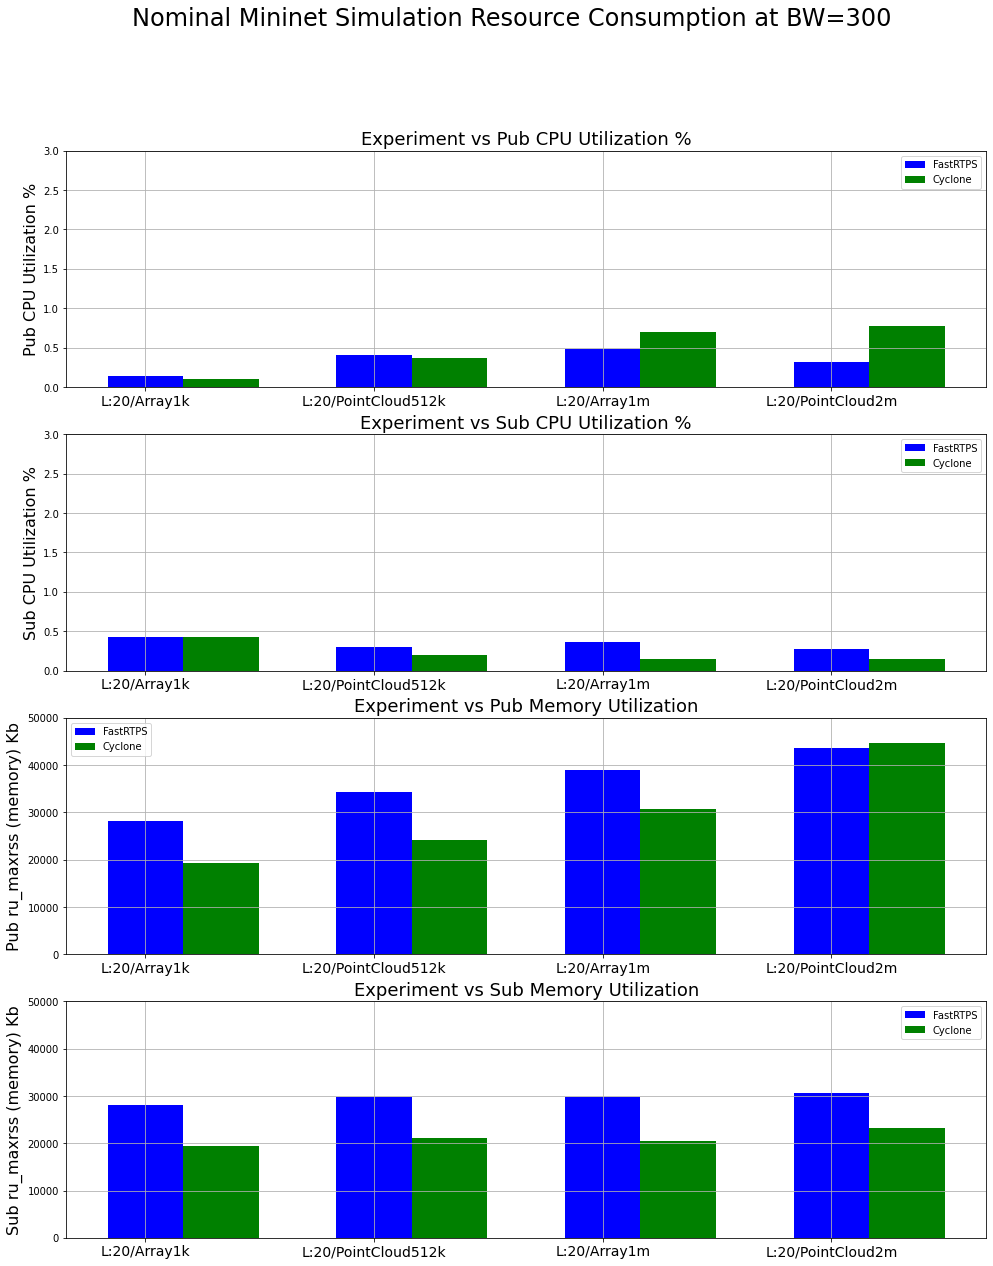

In [68]:
def generate_mininet_plot_good_conditions(fast_df, cyclone_df, render_set,super_title):
    to_plot = ['pub_mean_cpu_usage (%)','sub_mean_cpu_usage (%)',"pub_mean_ru_maxrss","sub_mean_ru_maxrss"]
    plot_units = ['Pub CPU Utilization %','Sub CPU Utilization %',"Pub ru_maxrss (memory) Kb","Sub ru_maxrss (memory) Kb"]
    titles = ["Experiment vs Pub CPU Utilization %","Experiment vs Sub CPU Utilization %","Experiment vs Pub Memory Utilization","Experiment vs Sub Memory Utilization"]
    y_extents = [[0,3],[0,3],[0,50000],[0,50000]]
    fig, ax = plt.subplots(len(to_plot))
    fig.set_size_inches(16.5,20) 
    fig.suptitle(super_title,fontsize=24)
    for idx,data_point in enumerate(to_plot):
        fast = []
        cyclone = [] 
        x_label = []
        for render in render_set:
            x_label.append("L:{0}/{1}".format(render[1],render[2]))
            fv = fast_df.loc[(fast_df['bandwidth'] == render[0]) & (fast_df["loss"] == render[1]) & (fast_df["message_type"]==render[2])]
            fast.append(fv[data_point].values[0])
            cv = cyclone_df.loc[(cyclone_df['bandwidth'] == render[0]) & 
                                (cyclone_df["loss"] == render[1]) & 
                                (cyclone_df["message_type"] == render[2])]
            cyclone.append(cv[data_point].values[0])
            
        x = np.arange(len(render_set))
        sz = 0.33
        ax[idx].grid(which="both")
        ax[idx].bar(x + 0.00, fast, color = 'b', width = sz,label="FastRTPS")
        ax[idx].bar(x + sz, cyclone, color = 'g', width = sz,label="Cyclone")
        ax[idx].set_ylim(y_extents[idx])
        ax[idx].set_xticks(x)
        ax[idx].set_xticklabels(x_label,rotation=0,fontsize=14)
        ax[idx].set_ylabel(plot_units[idx],fontsize=16)
        #ax[idx].set_xlabel("Mininet Experimental Conditions")
        ax[idx].set_title(titles[idx],fontsize=18)
        ax[idx].legend()
    return fig

good_examples = [
    (300,20,'Array1k'),
    (300,20,'PointCloud512k'),
    (300,20,'Array1m'),
    (300,20,'PointCloud2m')]
out = generate_mininet_plot_good_conditions(fast_df,cyclone_df,good_examples,"Nominal Mininet Simulation Resource Consumption at BW=300")    
plt.savefig("GoodBW300.png")

In [53]:
bw_54

[(54, 0, 'Array1m'),
 (54, 0, 'PointCloud2m'),
 (54, 0, 'PointCloud512k'),
 (54, 10, 'Array1k'),
 (54, 10, 'Array1m'),
 (54, 20, 'Array1k')]

In [54]:
bw_300_ok = [
    (300,20,'Array1k'),
    (300,20,'PointCloud512k'),
    (300,20,'Array1m'),
    (300,20,'PointCloud2m')
]

In [55]:
set(cyclone_df["message_type"].tolist())

{'Array1k', 'Array1m', 'PointCloud2m', 'PointCloud512k'}